
# Flower Classification with TPU #

In this notebook, we use Convolutional Neural Network to classify flowers into different classes. For more information on the data-set, see TensorFlow flowers [data set](https://www.tensorflow.org/datasets/catalog/tf_flowers). 
In order to speed up classificaiton, we make use of Tensor Processing Units (TPU), which are available from [Kaggle](https://www.kaggle.com/docs/tpu). 

We consider different augmentations to the data-set, and different regularisation and learning rates for the pre-trained models.

This notebook has been adapted from the following notebooks:
- Creating the flower data-sets is adapted from the the Ryan Holbrook's [notebook](https://www.kaggle.com/ryanholbrook/create-your-first-submission)
- Random blackout augmentation adapted from Tushar's [notebook](https://www.kaggle.com/tusharkendre/tpu-flowers)

### What is transfer learning

Transfer learning is a machine learning technique where a pre-trained source model trained on one task is re-purposed on another target dataset and similair task.

### Why do we use it 
Transfer learning is an optimization, a shortcut to saving time or getting better performance.

### Pip Installations

In [1]:
! pip install efficientnet

     |████████████████████████████████| 50 kB 1.4 MB/s 


In [2]:
# Imports
import math, re, os
import numpy as np
import tensorflow as tf
import pandas as pd
import random
import h5py 

from IPython.display import display
from matplotlib import pyplot as plt

import efficientnet.tfkeras as efn
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Dataset
from kaggle_datasets import KaggleDatasets

2022-11-01 13:46:12.834432: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-01 13:46:12.834582: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Defining the Distribution Strategy

TPUs have advantages with processing large matrix mutliplacations. For more information, see this TF [tutorial](https://codelabs.developers.google.com/codelabs/keras-flowers-tpu/index.html?index=..%2F..index#2). 
Below, we define the *distribution strategy*, which allows us to run out models on TPU. 

In [3]:
try: # See if TPU available
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else: # Otherwise use default strategy CPU / GPU
    strategy = tf.distribute.get_strategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync) #expect 8 if TPU

2022-11-01 13:46:20.477416: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-01 13:46:20.481240: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-01 13:46:20.481285: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 13:46:20.481315: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (491f31975aa5): /proc/driver/nvidia/version does not exist
2022-11-01 13:46:20.485348: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of accelerators:  8


## Loading the Competition Data 

In order to use TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). Fortunately, Kaggle has made this competition dataset available in a Google Coud Storage bucket. We also need to process the files in from [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics) into pairs of images and labels. 

The dataset already has folders for training (12753), validation (3712) and test (7382) data. However, the test dataset is not labelled - it is what is used to benchmark model performance on the leaderboard. So that we can have a labelled test dataset, we are going to divide the data in the validation folder into validation and test data-sets.

Thus we having the following datasets:

- Test dataset : 12753
- Validation dataset : 1856
- Test dataset : 1856
- Prediction dataset : 7382

Ignoring the prediction dataset (the unlabelled test dataset), this corresponds to roughly 80:10:10 split.

For tips on further optimising the data reading in process, see [here](https://www.tensorflow.org/guide/data_performance)

In [4]:
# illustration for how lambda functions work, and how to pass functions as arguments into others
def f(x, c):
    return x*c

def apply_func(f, x):
    print(f(x))
    
    
f_3 = lambda x: f(x, 3)

apply_func(f_3, 2)

6


## Image Processing Functions

In [5]:
# Image processing files
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image


def add_onehot_encoding(image,label):
    return image,tf.one_hot(label, len(CLASSES))


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) tuples


def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of (image, id) tuples 

def load_dataset(filenames, labeled=True, ordered=False):
    """
    Returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset  


# Random erasing (blockout) augmentation
def add_random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))


# (1,0,1,1,1,1)
def data_augment(image, label, flip=True, rotate=False, contrast=False, saturate=True, hue=False, random_erasing=True):
    """
    Applies random augmentations to the data:
    - flip: randomly flip along vertical axis
    - rotate: rotate by k*90 where k is chosen uniformly from {0,1,2,3}
    - contrast: randomly adjust the difference between darks and lights 
    - saturate: randomly adjusts the "colourfulness" of the image https://en.wikipedia.org/wiki/Colorfulness
    - hue: radnomly adjusts the hue of the image https://en.wikipedia.org/wiki/Hue 
    """
    if flip: image = tf.image.random_flip_left_right(image)              # flip along vertical axis
    if rotate: image = tf.image.rot90(image, k=random.choice([0,1,2,3])) # rotates image by k*90 degress  
    if contrast: image = tf.image.random_contrast(image, 0.8, 1.2)       # adjusts contrast 
    if saturate: image = tf.image.random_saturation(image, 0, 2)         # adjust saturation of images
    if hue: image = tf.image.random_hue(image, 0.1)                      # adds random hue changes to image
    if random_erasing: image = add_random_erasing(image)                  # adds blacked out sections to image

    return image, label   


# def prepare_dataset(file_name, labeled=True, ordered=False, training=False, augment=None):
def prepare_dataset(file_name, labeled=True, ordered=False, training=False, do_onehot_encoding=False):
    """
    Prepares a train, validation or test either with or without labels (as in the case of the predict set)
    Args:
        file_name: str, list of filenames of TFRecords
        labeled: bool, whether the TFRecords are image, label or image, id pairs
        ordered: bool, whether to fetch the file names in order 
        training: bool, if true, dataset is repeated and shuffled
        augment: function(image, label) -> (image, label) returns an augmented image
    """
    dataset = load_dataset(file_name, labeled=labeled, ordered = ordered)
    
    if do_onehot_encoding:
        dataset = dataset.map(add_onehot_encoding, num_parallel_calls=AUTO)

    if training:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO) # augments data with supplied function
        dataset = dataset.repeat()      # the training dataset must repeat for several epochs
        dataset = dataset.shuffle(2048) # 2048 is the buffersize 
    
    return dataset


def configure_for_performance(dataset):
    """
    Batches and prefetches data. See cache, interleave also in https://www.tensorflow.org/guide/data_performance
    """
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)    # prefetch next batch while training (autotune prefetch buffer size)
    return dataset
    

def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    
    return labels


def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [6]:
def plot_label_dist(label_counts, name = "", y_blank=False):
    plt.barh(label_counts[:,0], label_counts[:,1].astype(int), color="grey")
    plt.xlabel("Count")
    plt.title(f"{name} {len(label_counts)}")
    if y_blank: plt.yticks([])
        

In [7]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                  

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') #define path to google cloud storage bucket

# we use the 512x512x3 data 
IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + f'/tfrecords-jpeg-{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}'
AUTO = tf.data.experimental.AUTOTUNE

# note we are going to split up the validation folder into validation and test data
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VAL_TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
PRED_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

print("Number of observations in each file:")
NUM_TRAIN = count_data_items(TRAINING_FILENAMES)
NUM_VAL_TEST = count_data_items(VAL_TEST_FILENAMES)
NUM_VAL = NUM_VAL_TEST//2
NUM_TEST = NUM_VAL_TEST - NUM_VAL
NUM_PRED = count_data_items(PRED_FILENAMES)
print(f"Train: {NUM_TRAIN}\nValidation: {NUM_VAL}\nTest: {NUM_TEST}\nUnlabelled Test: {NUM_PRED}")

2022-11-01 13:46:27.972540: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-11-01 13:46:28.062129: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-11-01 13:46:28.132163: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Number of observations in each file:
Train: 12753
Validation: 1856
Test: 1856
Unlabelled Test: 7382


In [8]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Define augmented_training
train_ds = configure_for_performance(
    prepare_dataset(
        TRAINING_FILENAMES, labeled=True, training=True, do_onehot_encoding=False
    )
)
val_test_ds = prepare_dataset(VAL_TEST_FILENAMES, labeled=True, do_onehot_encoding=False)
val_ds = configure_for_performance(val_test_ds.take(NUM_VAL))
test_ds = configure_for_performance(val_test_ds.skip(NUM_VAL).take(NUM_TEST))
pred_ds = configure_for_performance(prepare_dataset(PRED_FILENAMES, labeled=False, ordered=True))


# print("Training:", unaugmented_train_ds)
print("Training:", train_ds)
print ("Validation:", val_ds)
print("Test:", test_ds)
print("Predict:", pred_ds)

Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Predict: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>


### Train dataset (with random Augmentations)

2022-11-01 13:46:33.440271: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 87, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667310393.436688157","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 87, Output num: 0","grpc_status":3}


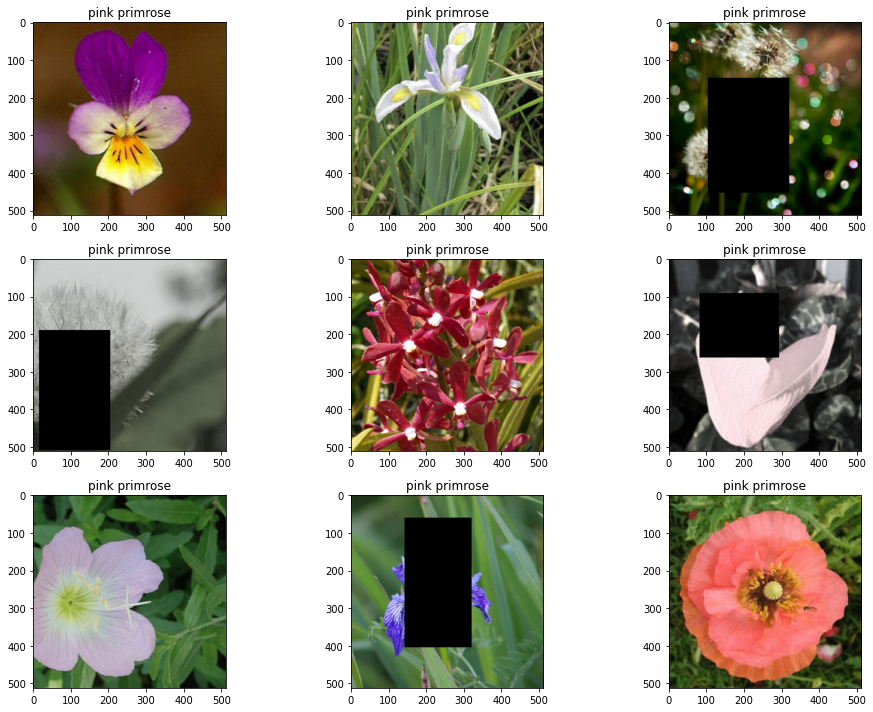

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(14,10))
axs = axs.flatten()

#Plot an example from the training data-set
for (img, class_ind_arr), ax in zip(train_ds.unbatch().take(9),  axs):
    class_ind = np.argmax(class_ind_arr, -1)
    ax.imshow(img)
    ax.set_title(CLASSES[class_ind])

plt.tight_layout()
plt.show()

## Test Dataset

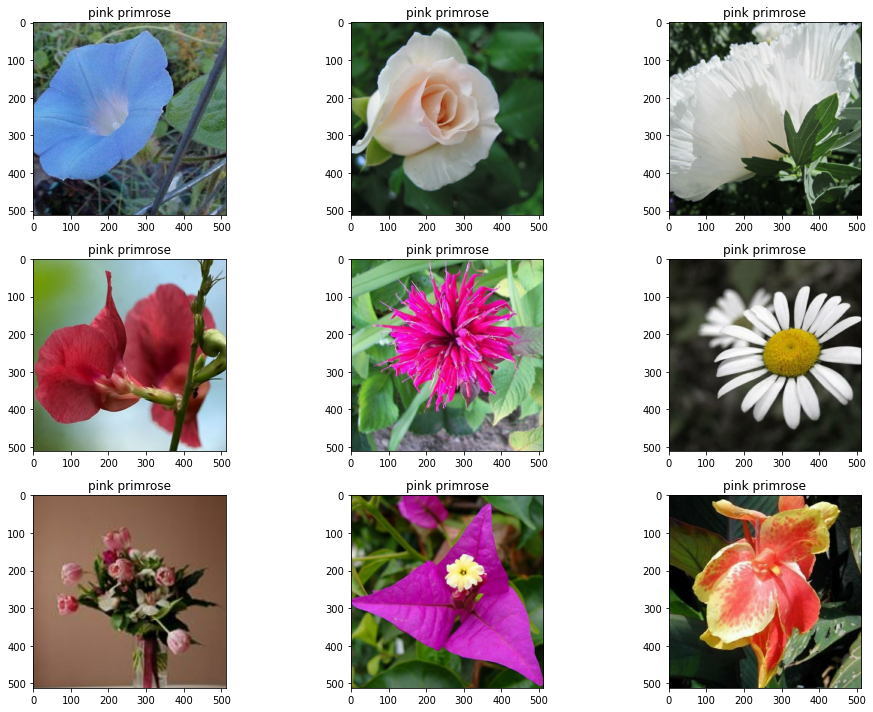

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(14,10))
axs = axs.flatten()
#Plot an example from the training data-set
for (img, class_ind_arr), ax in zip(test_ds.unbatch().take(9),  axs):
    class_ind = np.argmax(class_ind_arr, -1)
    ax.imshow(img)
    ax.set_title(CLASSES[class_ind])

plt.tight_layout()
plt.show()

## Plot Distributions of Classes in Train, Test, Validation sets

We want to see how many flowers there are in each class. This will give us a sense of how well a most frequent label classifier would do. 

In [11]:
#This takes a little while
prepare_deterministic = lambda file_name: prepare_dataset(file_name, labeled=True, ordered=True)
train = prepare_deterministic(TRAINING_FILENAMES)
val_test = prepare_deterministic(VAL_TEST_FILENAMES)
val = val_test.take(NUM_VAL)
test = val_test.skip(NUM_VAL).take(NUM_TEST)

#see if there is a more effecient ways of extracting the labels/class indices from each dataset
get_indices = lambda ds: np.array(list(ds.map(lambda image, index: index).as_numpy_iterator()))
y_train = get_indices(train)
y_val = get_indices(val)
y_test = get_indices(test)
print("Done complicated label extraction")

#get label counts - figure out how to make np array mixed type - it currently converts the counts to strings
count_labels = lambda indices: np.asarray([[label, (indices == index).sum()] for index, label in enumerate(CLASSES)])
train_counts = count_labels(y_train)
val_counts = count_labels(y_val)
test_counts = count_labels(y_test)

Done complicated label extraction


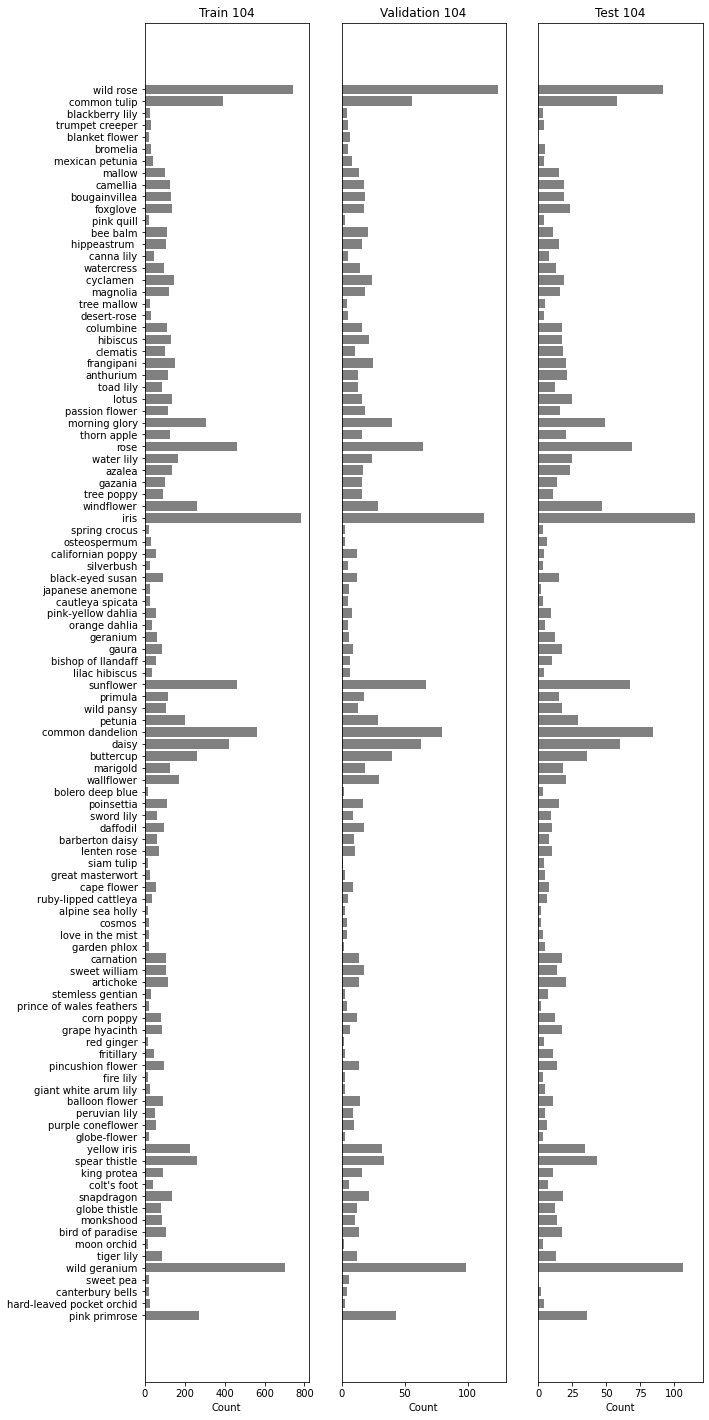

In [12]:
plt.figure(figsize=(10,25))
plt.subplot(1,3,1)
plot_label_dist(train_counts, "Train")
plt.subplot(1,3,2)
plot_label_dist(val_counts, "Validation", True)
plt.subplot(1,3,3)
plot_label_dist(test_counts, "Test", True)

## Weak Baseline

If we classified every observation in the test data-set with the most frequent label in the training dataset, *iris*, we would achieve an accuracy of 5.71%.

In [13]:
ind = np.argmax(train_counts[:,1].astype(int)) # index of most frequent label
m_f_l = train_counts[ind,0]                    # most frequent label - iris
tc = float(test_counts[ind,1])                 # number of occurences of iris in test set
print(f"Most frequent label classifier accuracy: {round(tc/NUM_TEST,4)}")

Most frequent label classifier accuracy: 0.062


# Model Design 

We make use of *transfer learning*, where we use a pretrained model and append additional fully connected layers on the end so we can exploit the pretrained "learnt" representations, and then just have to learn how to map these learnt representations to classifications. We may consider more models, but at this stage, we consider:

- VGGNet [(Simonyan and Zisserman, 2014)](https://arxiv.org/abs/1409.1556)
- ResNet [(He et al, 2016)](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html)
- Xception [(François Chollet, 2017)](https://arxiv.org/abs/1610.02357)
- DenseNet [(Huang et al, 2016)](https://arxiv.org/abs/1608.06993)
- EfficientNet [(Mingxing and Quoc, 2019)](https://arxiv.org/abs/1905.11946)

These models were pretrained on the [ImageNet](http://image-net.org/) dataset. At a later stage, we can also start fine tuning these models: see [here](https://keras.io/guides/transfer_learning/) 

### Metrics and Loss

We use cross-entropy as the loss function. The reason we use `sparse_categorical_crossentropy` as opposed to `categorical_crossentropy` is since the responses that are not hot-one encodings, e.g. [0,0,1], but rather as numbers, e.g. [3]. 

### TPU

For training these models with TPU, as Ryan Holbrook said, *"The distribution strategy we created earlier contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope`. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define your model in a `strategy.scope()` context."*

## Model building functions

In [14]:
def build_efficientnet_model(dropout=None):
    feature_model = efn.EfficientNetB7(
        weights= "noisy-student",
        include_top = False ,
        input_shape=[*IMAGE_SIZE, 3]
    )

    feature_model.trainable = True # If False, Freezes all the pretrained models weights

    model = tf.keras.Sequential(
        name=f"{feature_model.name}_drop{dropout}_units"
    )
    model.add(feature_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D()) # add global average pooling

    if dropout:
        model.add(tf.keras.layers.Dropout(dropout)) # optionally add dropout


    model.add(tf.keras.layers.Dense(len(CLASSES), activation='softmax')) # final fully connected layer

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy', # Don't use spare if we do not have one-hot-encoded the features
        metrics=['sparse_categorical_accuracy'],
    )

    display(model.summary())
    
    return model


def build_densenet_model(dropout=None):
    feature_model = tf.keras.applications.densenet.DenseNet201(
        weights= "imagenet",
        include_top = False ,
        input_shape=[*IMAGE_SIZE, 3]
    )

    feature_model.trainable = True # If False, Freezes all the pretrained models weights

    model = tf.keras.Sequential(
        name=f"{feature_model.name}_drop{dropout}_units"
    )
    model.add(feature_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D()) # add global average pooling

    if dropout:
        model.add(tf.keras.layers.Dropout(dropout)) # optionally add dropout


    model.add(tf.keras.layers.Dense(len(CLASSES), activation='softmax')) # final fully connected layer

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy', # Don't use spare if we do not have one-hot-encoded the features
        metrics=['sparse_categorical_accuracy'],
    )

    display(model.summary())
    
    return model


def build_resnet_model(dropout=None):
    feature_model = tf.keras.applications.ResNet50V2(
        weights= "imagenet",
        include_top = False ,
        input_shape=[*IMAGE_SIZE, 3]
    )

    feature_model.trainable = True # If False, Freezes all the pretrained models weights

    model = tf.keras.Sequential(
        name=f"{feature_model.name}_drop{dropout}_units"
    )
    model.add(feature_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D()) # add global average pooling

    if dropout:
        model.add(tf.keras.layers.Dropout(dropout)) # optionally add dropout

    model.add(tf.keras.layers.Dense(len(CLASSES), activation='softmax')) # final fully connected layer

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy', # Don't use spare if we do not have one-hot-encoded the features
        metrics=['sparse_categorical_accuracy'],
    )

    display(model.summary())
    
    return model

### Callbacks

We make use of early stopping and a learning rate scheduler. For early stopping, we monitor the validation loss and terminate training if it stops decreasing for 3 epochs (`patience=3`). The scheduler caues the learning rate to ramp up for a number of epochs, sustain for a number of epochs and then decay. 

Why the ramp up: [Someone's StackOverflow opinion](https://stackoverflow.com/questions/55933867/what-does-learning-rate-warm-up-mean)

In [15]:
def get_callbacks():
    #early stopping
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    #learning rate scheduler
    lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)
    
    return [es_callback, lr_callback]

def exponential_lr(
    epoch,
    start_lr = 0.00001,
    min_lr = 0.00001,
    max_lr = 0.00005 * strategy.num_replicas_in_sync,
    rampup_epochs = 5,
    sustain_epochs = 0,
    exp_decay = 0.8
):
    # linear increase from start to rampup_epochs
    if epoch < rampup_epochs:
        lr = ((max_lr - start_lr) / rampup_epochs * epoch + start_lr)
    # constant max_lr during sustain_epochs
    elif epoch < rampup_epochs + sustain_epochs:
        lr = max_lr
    # exponential decay towards min_lr
    else:
        lr = ((max_lr - min_lr) *
              exp_decay**(epoch - rampup_epochs - sustain_epochs) +
              min_lr)
    return lr

### (Ignore) Code for finding best dropout parameter for each model

In [16]:
# def find_best_dropout(model):
#     # Searching for best drop out

#     dropout_params = np.round(np.linspace(0.4, 0.005, 5), 6)

#     drop_out_models = [
#         build_model(model, dropout = float(str(np.round(param, 4))))
#         for param in dropout_params
#     ]

#     for m in models:
#         display(m.summary())
        
        
        
# #let training begin
# for model in baseline_models:
#     histories[model.name] = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=EPOCHS,
#         steps_per_epoch=STEPS_PER_EPOCH,
#         callbacks=get_callbacks())

In [17]:
# EPOCHS = 1
# STEPS_PER_EPOCH = 10  #NUM_TRAIN // BATCH_SIZE

# # Find best dropout for Models
# base_models = [
#     tf.keras.applications.densenet.DenseNet201,
# #     tf.keras.applications.Xception,
# ]
# dropout_params = np.round(np.linspace(0.4, 0.005, 5), 6)

# for model in base_models:
#     print("Model Name", str(model))
#     drop_out_models = [
#         build_model(model, dropout = np.round(param, 4) )
#         for param in dropout_params
#     ]
    
#     # Train model
#     history = {}
# #     val_sparse_categorical_accuracy_scores = []
#     for drop_out_model in drop_out_models:
#         history[drop_out_model.name] = drop_out_model.fit(
#             train_ds,
#             validation_data=val_ds,
#             epochs=EPOCHS,
#             steps_per_epoch=STEPS_PER_EPOCH,
#             callbacks=get_callbacks()
#         )
#         val_sparse_categorical_accuracy = np.max(history[drop_out_model.name].history["val_sparse_categorical_accuracy"])
#         val_sparse_categorical_accuracy_scores.append(val_sparse_categorical_accuracy)
#         print("submodel history:\n", history[drop_out_model.name].history)
        
# #     selection_feature = "val_sparse_categorical_accuracy"
# #     val_sparse_categorical_accuracy_scores = [np.max(history[m.name].history[selection_feature]) for m in drop_out_models]
#     best_dropout_pos = np.argmax(val_sparse_categorical_accuracy_scores)
#     best_dropout = best_dropout_pos[dropout_scores]
#     best_score = scores[best_dropout]
#     print(f"Best dropout is {best_dropout} with score of {best_score}")
#     print("history", history)


# print("Done finding best dropout")

# Model building and fitting

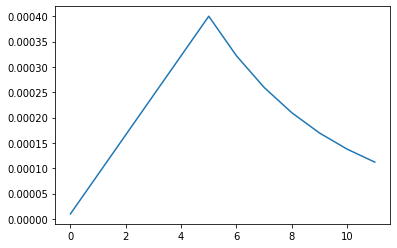

In [18]:
# Total number of steps (batches of samples) per epoch 
STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE
EPOCHS = 12


#illsutration of learning rate
rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
plt.show()

histories = {} #collect the train and val trajectories for each model

In [19]:
# Models I looked at
# - DenseNet201
# - ResNet50V2
# - EfficientNetB7

baseline_models = []
with strategy.scope():
    # Add DenseNet Model
    model = build_densenet_model(dropout=0.1)
    baseline_models.append(model)
    
    # Add Efficient Net Model
    model = build_efficientnet_model(dropout=0.1)
    baseline_models.append(model)
    
    # Add Res Net Model
#     model = build_resnet_model(dropout=0.1038)
#     baseline_models.append(model)


74842112/74836368 [==============================] - 0s 0us/step
Model: "densenet201_drop0.1_units"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


None

258072576/258068648 [==============================] - 14s 0us/step
Model: "efficientnet-b7_drop0.1_units"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


None

In [20]:
# Let training begin
for model in baseline_models:
    histories[model.name] = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks()
    )

Epoch 1/12

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
99/99 [==============================] - 232s 770ms/step - loss: 2.5862 - sparse_categorical_accuracy: 0.4219 - val_loss: 3.7883 - val_sparse_categorical_accuracy: 0.2478


2022-11-01 13:53:09.702378: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 178209, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667310789.702288152","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 178209, Output num: 0","grpc_status":3}


Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000880000037997961.
99/99 [==============================] - 56s 563ms/step - loss: 0.8902 - sparse_categorical_accuracy: 0.7797 - val_loss: 2.2918 - val_sparse_categorical_accuracy: 0.5022
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000688000039048493.
99/99 [==============================] - 56s 564ms/step - loss: 0.5478 - sparse_categorical_accuracy: 0.8620 - val_loss: 0.9702 - val_sparse_categorical_accuracy: 0.7737
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005152000233158469.
99/99 [==============================] - 56s 570ms/step - loss: 0.3787 - sparse_categorical_accuracy: 0.9043 - val_loss: 0.4284 - val_sparse_categorical_accuracy: 0.8939
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004230400046147406.
99/99 [==============================] - 56s 564ms/step - loss: 0.2388 - sparse_categorical_accuracy: 0.9400

2022-11-01 14:09:22.748439: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 292181, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667311762.748298179","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 292181, Output num: 1","grpc_status":3}


Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000880000037997961.
99/99 [==============================] - 95s 956ms/step - loss: 0.8856 - sparse_categorical_accuracy: 0.7688 - val_loss: 0.6821 - val_sparse_categorical_accuracy: 0.8292
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000688000039048493.
99/99 [==============================] - 95s 961ms/step - loss: 0.5276 - sparse_categorical_accuracy: 0.8573 - val_loss: 0.3390 - val_sparse_categorical_accuracy: 0.9240
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005152000233158469.
99/99 [==============================] - 95s 957ms/step - loss: 0.3371 - sparse_categorical_accuracy: 0.9083 - val_loss: 0.2513 - val_sparse_categorical_accuracy: 0.9397
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004230400046147406.
99/99 [==============================] - 95s 959ms/step - loss: 0.2395 - sparse_categorical_accuracy: 0.9347

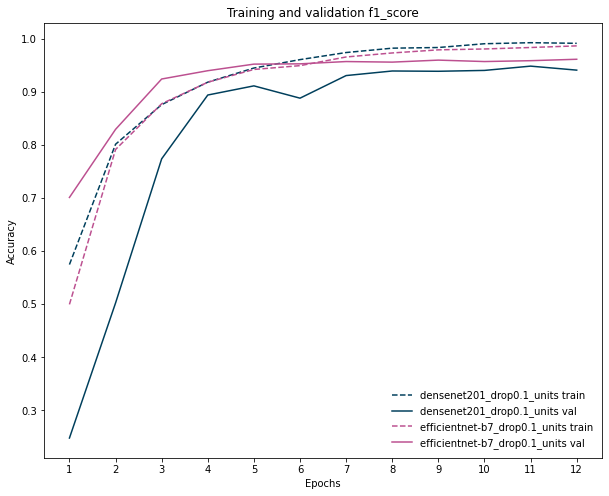

In [21]:
# Plot Train and Validation accuracy
plt.figure(figsize=(10,8))
#define colours (add more colours if more models considered)
colours = ["#003f5c","#bc5090", "#228b22", "#ff0000"]      

for i, model in enumerate(baseline_models):
    model_name = model.name
    history_dict = histories[model_name].history
    loss = history_dict['sparse_categorical_accuracy']
    val_loss = history_dict['val_sparse_categorical_accuracy']

    epochs = range(1, len(loss) + 1)
    plt.xticks(np.arange(1, len(epochs)+1, 1))
    plt.plot(epochs, loss, label=f"{model_name} train", linestyle="--", color=colours[i])
    plt.plot(epochs, val_loss, label=f"{model_name} val", color=colours[i])
    plt.title('Training and validation f1_score')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

plt.legend(frameon=False)
plt.show()

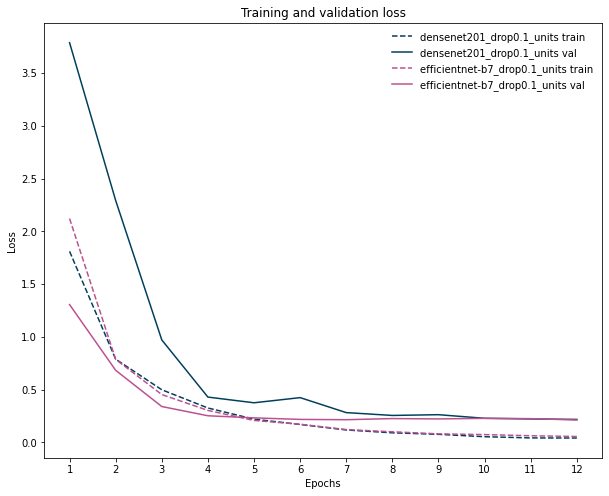

In [22]:
# Plot Train and Validation loss
plt.figure(figsize=(10,8))

for i, model in enumerate(baseline_models):
    model_name = model.name
    history_dict = histories[model_name].history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.xticks(np.arange(1, len(epochs)+1, 1))
    plt.plot(epochs, loss, label=f"{model_name} train", linestyle="--", color=colours[i])
    plt.plot(epochs, val_loss, label=f"{model_name} val", color=colours[i])
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

plt.legend(frameon=False)
plt.show()

## Evaluate model performance on the test set

In [23]:
for model in baseline_models:
    print(f"Evaluating model: {model.name}")
    evaluation = model.evaluate(test_ds)
    print()

Evaluating model: densenet201_drop0.1_units
15/15 [==============================] - 5s 165ms/step - loss: 0.2373 - sparse_categorical_accuracy: 0.9483

Evaluating model: efficientnet-b7_drop0.1_units


2022-11-01 14:27:35.909705: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 358954, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667312855.909598652","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 358954, Output num: 0","grpc_status":3}


15/15 [==============================] - 5s 210ms/step - loss: 0.2292 - sparse_categorical_accuracy: 0.9644



In [24]:
# Save histories
save_model_histories = False

if save_model_histories:
    # Make directory for histories
    history_dir = "./model_history"
    os.makedirs(history_dir, exist_ok=True)

    for model in baseline_models:
        model_name = model.name
        model_train_history = histories[model_name].history

        hist_file_name = model_name + "_training_history.csv"
        csv_path = os.path.join(history_dir, hist_file_name)

        # Save to csv file
        df = pd.DataFrame(model_train_history)
        df.to_csv(csv_path)
        print(f"Saved history to {csv_path}")


In [25]:
# Save Weights
save_model_weights = False

if save_model_weights:
    # Make directory for model weights
    weights_dir = "./model_weights"
    os.makedirs(weights_dir, exist_ok=True)

    for model in baseline_models:
        model_name = model.name
        weights_file_name = model_name + "_trained_weights.h5"
        h5_path = os.path.join(weights_dir, weights_file_name)

        #save model weights
        model.save_weights(h5_path) 
        print(f"Saved weights to {h5_path}")

## Hyper-parameter optimisation

1. Different amounts of dropout - lienar search on best model
2. Different types of image augmentation 

In [26]:
# Find Best Alpha with Validation sets

# f1_with average='marco' means: Calculate metrics for each label, and find their unweighted mean. 
# This does not take label imbalance into account.

def find_best_alpha(model_1, model_2, validation_ds, one_hot_encoded=False):
    images_ds = validation_ds.map(lambda image, label: image)
    val_true_labels = get_labels_from_tfdataset(validation_ds)

    if one_hot_encoded:
        val_true_labels = np.argmax(val_true_labels, axis=-1)

    m1_pred = model_1.predict(images_ds)
    m2_pred = model_2.predict(images_ds)

    scores = []
    for alpha in np.linspace(0,1,100):
        val_probabilities = alpha * m1_pred + (1-alpha) * m2_pred
        val_predictions = np.argmax(val_probabilities, axis=-1)
        
        scores.append(f1_score(val_true_labels, val_predictions, labels=range(104), average='macro'))

    best_alpha = np.argmax(scores)/100
    best_score = np.max(scores)
    return best_alpha, best_score


#### After looking at the results of countless runs - the combination of ensenet201 and efficientnet-b7 are the best for the ensemble model


In [27]:
# # Loop of all combinations of models
# model_combinations = [
#     [baseline_models[0], baseline_models[1]],
#     [baseline_models[0], baseline_models[2]],
#     [baseline_models[1], baseline_models[2]],
# ]

# all_scores_and_alphas = []
# for mod_1, mod_2 in model_combinations:
#     print(f"Finding Best alpha between {mod_1.name} vs {mod_2.name}")
#     sub_best_alpha, sub_best_score = find_best_alpha(model_1=mod_1, model_2=mod_2, validation_ds=val_ds, one_hot_encoded=False)
#     all_scores_and_alphas.append((sub_best_alpha, sub_best_score, mod_1, mod_2))
#     print(f"Best found alpha: {sub_best_alpha} with score of {sub_best_score}")
#     print()


# # Get Best
# sorted_scores_and_alphas = sorted(all_scores_and_alphas, key=lambda x: x[1]) # Sort by score
# best_alpha, best_score, best_model_1, best_model_2 = sorted_scores_and_alphas[-1] # Select the bigger F1 score on validation set

# print(f"Best Ensemble Models: {best_model_1.name} and {best_model_2.name}")
# print(f"Final Alpha = {best_alpha}")

In [28]:
best_model_1 = baseline_models[0]
best_model_2 = baseline_models[1]

print(f"Finding Best alpha between {best_model_1.name} vs {best_model_2.name}")
best_alpha, best_score = find_best_alpha(model_1=best_model_1, model_2=best_model_2, validation_ds=val_ds, one_hot_encoded=False)
print(f"Best found alpha: {best_alpha} with score of {best_score}")

Finding Best alpha between densenet201_drop0.1_units vs efficientnet-b7_drop0.1_units


2022-11-01 14:29:00.508753: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 360103, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667312940.508663813","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 360103, Output num: 0","grpc_status":3}


Best found alpha: 0.54 with score of 0.024710820733912786


### Confusion Matrix of Validation Data

Plot a confusion matrix to evaluate our models accuracy

In [29]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    
    plt.show()
    

def create_and_display_confusion_matrix(val_ds, best_model_1, best_model_2, alpha):
    # since we are splitting the dataset and iterating separately on images and labels, order matters.
    cm_predictions = predict_ensemble(dataset=val_ds, model1=best_model_1, model2=best_model_2, alpha=alpha)

    labels_ds = val_ds.map(lambda image, label: label).unbatch()

    one_hot_encoded = False
    if one_hot_encoded:
        cm_correct_labels_one = next(iter(labels_ds.batch(NUM_VAL))).numpy() # get everything as one batch
        cm_correct_labels = np.argmax(cm_correct_labels_one_hot, axis=-1)
    else:
        cm_correct_labels = next(iter(labels_ds.batch(NUM_VAL))).numpy() # get everything as one batch

    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')

#     cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print(f"f1 score: {score:.3f}, precision: {precision:.3f}, recall: {recall:.3f}")


def predict_ensemble(dataset, model1, model2, alpha=0.5):
    pred_images_ds = dataset.map(lambda image, idnum: image) #extract images from pred_ds

    probabilities_1 = model1.predict(pred_images_ds) 
    probabilities_2 = model2.predict(pred_images_ds)

    probabilities = alpha * probabilities_1 + (1 - alpha) * probabilities_2
    predictions = np.argmax(probabilities, axis=-1)
    return predictions

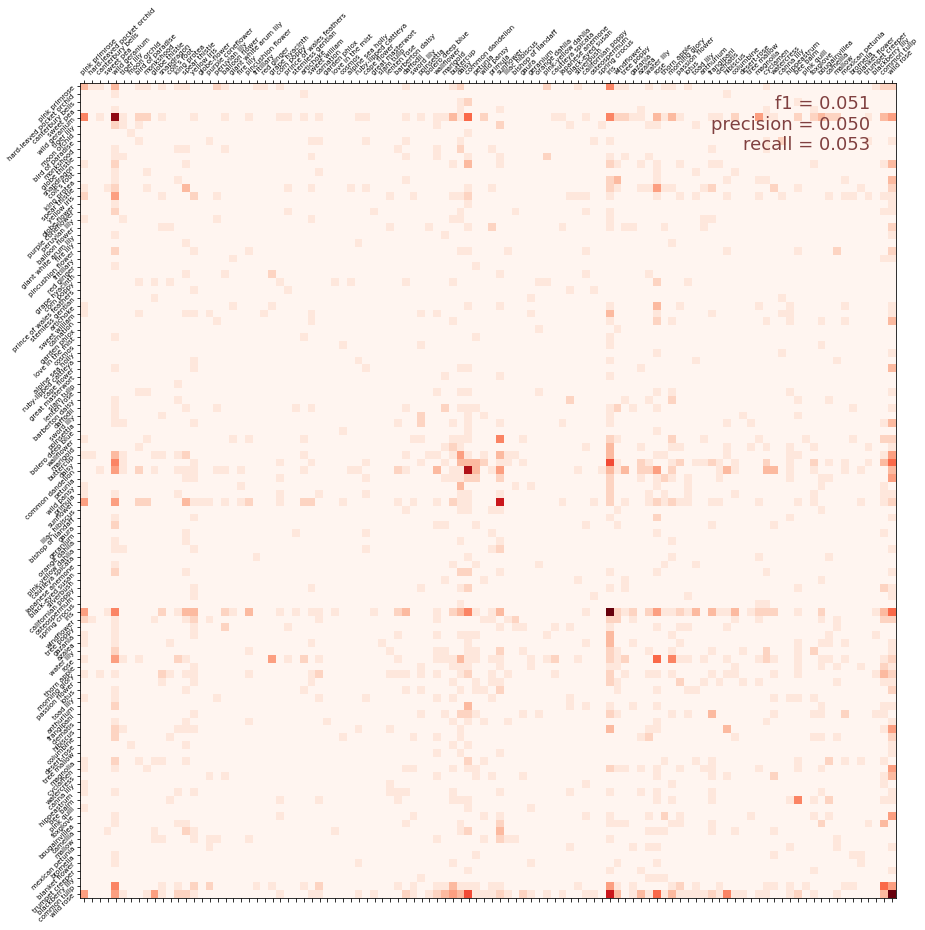

f1 score: 0.051, precision: 0.050, recall: 0.053


In [30]:
create_and_display_confusion_matrix(val_ds=val_ds, best_model_1=best_model_1, best_model_2=best_model_2, alpha=best_alpha)

## Make Predictions

We will use an ensemble of two models to make predictions

In [31]:
predictions = predict_ensemble(dataset=pred_ds, model1=best_model_1, model2=best_model_2, alpha=best_alpha)
print(predictions)

[ 67  28  83 ...  53 102  62]


2022-11-01 14:30:16.941143: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 362023, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667313016.939335649","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 362023, Output num: 0","grpc_status":3}


In [32]:
# Get image ids from test set and convert to unicode
pred_ids_ds = pred_ds.map(lambda image, idnum: idnum).unbatch()
pred_ids = next(iter(pred_ids_ds.batch(NUM_PRED))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([pred_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,70
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82
